<form action="https://nbviewer.jupyter.org/github/prmiles/pymcmcstat/blob/master/tutorials/index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Specifying Sample Variables
Author(s): Paul Miles | Date Created: July 12, 2018

Many models require a set of parameters as input; however, it is not always of interest to estimate those parameter's posterior distribution.  The [pymcmcstat](https://github.com/prmiles/pymcmcstat/wiki) package will allow you to send static parameters to the model along with the parameters being sampled.  We demonstrated this feature by considering a simple linear model.

In [1]:
# Import required packages
import numpy as np
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
np.seterr(over = 'ignore');

We define a linear model function and corresponding sum-of-squares function.

In [2]:
# define test model function
def linear_model(xdata, theta):
    m = theta[0]
    b = theta[1]
    nrow, ncol = xdata.shape
    y = np.zeros([nrow, 1])
    y[:, 0] = m*xdata.reshape(nrow,) + b
    return y

def ssfun(theta, data):
    xdata = data.xdata[0]
    ydata = data.ydata[0]
    # eval model
    ymodel = linear_model(xdata, theta)
    # calc sos
    ss = sum((ymodel[:, 0] - ydata[:, 0])**2)
    return ss

# Generate Synthetic Data
We generate sythetic data using the linear model and adding observation errors
$$y_i = 2x_i + 3 + \epsilon_i, \;\; \epsilon_i \sim N(0, 0.1)$$
We plot the data and linear model and see randomly distributed noise with respect to the model response.

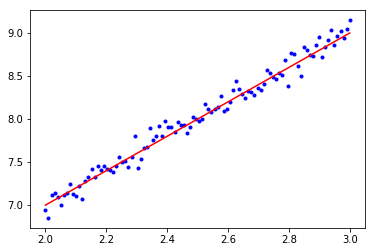

In [3]:
nds = 100
x = np.linspace(2, 3, num=nds).reshape(nds, 1)
theta_data = np.array([2.0, 3.0])
y = linear_model(x, theta_data) + 0.1*np.random.standard_normal(x.shape)
plt.plot(x, y, '.b');
plt.plot(x, linear_model(x, theta_data), '-r');

# Initialize MCMC Object
- initialize data structure
- define simulation options

In [4]:
# Initialize MCMC object
mcstat = MCMC()
mcstat.data.add_data_set(x, y)
mcstat.simulation_options.define_simulation_options(
    nsimu=int(5.0e3),
    updatesigma=True,
    method='dram')
mcstat.model_settings.define_model_settings(sos_function=ssfun)

# Specify Sample
When defining the model parameters, we can turn the sampling on or off by specifying the value of the `sample` argument.
- `sample = True`: Parameter will be treated as a random variable and be included in the sampling chain.  This is the default behavior.
- `sample = False`: Parameter will be held constant at the initial value defined by the user.

In [5]:
mcstat.parameters.add_model_parameter(
    name='m',
    theta0=2.,
    sample=False)
mcstat.parameters.add_model_parameter(
    name='b',
    theta0=5.,
    minimum=-10,
    maximum=100,
    sample=True)

# Run Simulation
Observe that the only parameters displayed are the ones where `sample = True`.

In [6]:
mcstat.run_simulation()
# Extract results
results = mcstat.simulation_results.results
chain = results['chain']
s2chain = results['s2chain']
sschain = results['sschain']
names = results['names']

# define burnin
burnin = 2000
# display chain statistics
mcstat.chainstats(chain[burnin:, :], results)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         b:      5.00 [   -10.00,    100.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 1.6 sec
---------------------
name      :       mean        std     MC_err        tau     geweke
b         :     3.0184     0.0087     0.0004     5.9851     0.9995
---------------------


# MCMC Plots
The plots only show the results of the sampled parameters `b`.

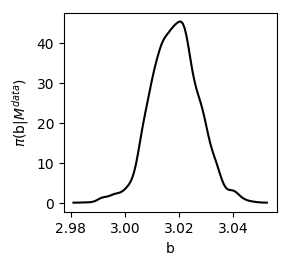

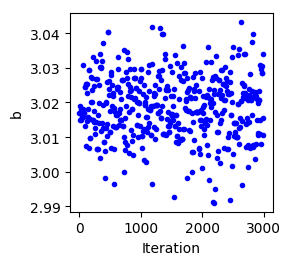

In [8]:
# generate mcmc plots
mcpl = mcstat.mcmcplot # initialize plotting methods
mcpl.plot_density_panel(chain[burnin:, :], names,
                        figsizeinches=(3, 3))
mcpl.plot_chain_panel(chain[burnin:, :], names,
                      figsizeinches=(3, 3));

# Plot Prediction/Credible Intervals

Generating credible/prediction intervals:


Interval generation complete



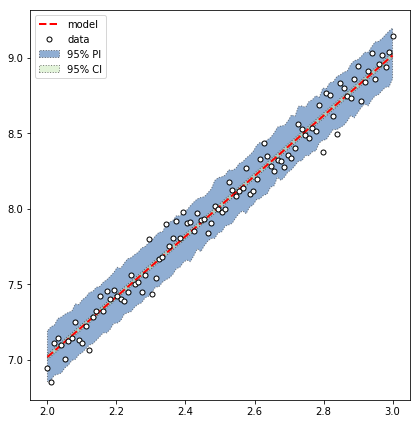

In [9]:
# generate prediction intervals
def pred_modelfun(preddata, theta):
    return linear_model(preddata.xdata[0], theta)
    
mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=mcstat.data,
    modelfunction=pred_modelfun,
    burnin=burnin)
mcstat.PI.generate_prediction_intervals(calc_pred_int=True)
# plot prediction intervals
data_display = dict(
    marker='o',
    markersize=5,
    markeredgecolor='k',
    markeredgewidth=1,
    markerfacecolor='w')
model_display = dict(color='r', linestyle='--')
mcstat.PI.plot_prediction_intervals(
    adddata=True,
    plot_pred_int=True,
    figsizeinches=(6, 6),
    model_display=model_display,
    data_display=data_display);